In [2]:
import pandas as pd
file_path = "./lending_club_data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv"
df = pd.read_csv(file_path, low_memory=False, nrows=5000)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (5000, 151)
Columns: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_stat

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df['loan_status'].value_counts()


loan_status
Fully Paid            3637
Charged Off            816
Current                514
Late (31-120 days)      29
In Grace Period          3
Late (16-30 days)        1
Name: count, dtype: int64

In [4]:
# look only at fully paid and charged off
df_binary = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

#Target variable: Charged Off → 1, Fully Paid → 0
df_binary['default'] = df_binary['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

#
print(df_binary['default'].value_counts())
df_binary[['loan_status', 'default']].head(5)


default
0    3637
1     816
Name: count, dtype: int64


,loan_status,default
0,Fully Paid,0
1,Fully Paid,0
2,Fully Paid,0
4,Fully Paid,0
5,Fully Paid,0


In [13]:
selected_cols = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                 'annual_inc', 'purpose', 'dti', 'fico_range_low','revol_util', 'inq_last_6mths', 'open_acc', 'total_acc', 'default']
# fraction of loan to income
df_binary['loan_to_income'] = df_binary['loan_amnt'] / df_binary['annual_inc']
selected_cols.append('loan_to_income')
df_model = df_binary[selected_cols].copy()



In [18]:
#Preprocessing--> handlin NAn to 'unknown'
df_model['emp_length'] = df_model['emp_length'].fillna('Unknown')
#changing string to float(number)
df_model_encoded = pd.get_dummies(df_model, drop_first=True)

# Filling in the NaN
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df_model_encoded.drop('default', axis=1))




In [27]:
#model traning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = pd.DataFrame(X_imputed, columns=df_model_encoded.drop('default', axis=1).columns)
y = df_model_encoded['default'] #target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.68      0.78       728
           1       0.32      0.66      0.43       163

    accuracy                           0.68       891
   macro avg       0.61      0.67      0.60       891
weighted avg       0.79      0.68      0.71       891

[[498 230]
 [ 56 107]]


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
import numpy as np

coefficients = pd.Series(model.coef_[0], index=X.columns)
important_features = coefficients.sort_values(ascending=False)

print(important_features.head(10)) 
print(important_features.tail(10)) 


int_rate                      0.170091
inq_last_6mths                0.042968
open_acc                      0.039935
home_ownership_RENT           0.032585
dti                           0.019133
purpose_debt_consolidation    0.013597
grade_D                       0.012888
grade_B                       0.009534
term_ 60 months               0.009108
sub_grade_C4                  0.008060
dtype: float64
sub_grade_A3               -0.003068
installment                -0.003217
fico_range_low             -0.003816
purpose_home_improvement   -0.004534
emp_length_< 1 year        -0.005046
purpose_credit_card        -0.005514
purpose_other              -0.005612
sub_grade_A2               -0.006410
emp_length_10+ years       -0.007247
total_acc                  -0.012458
dtype: float64


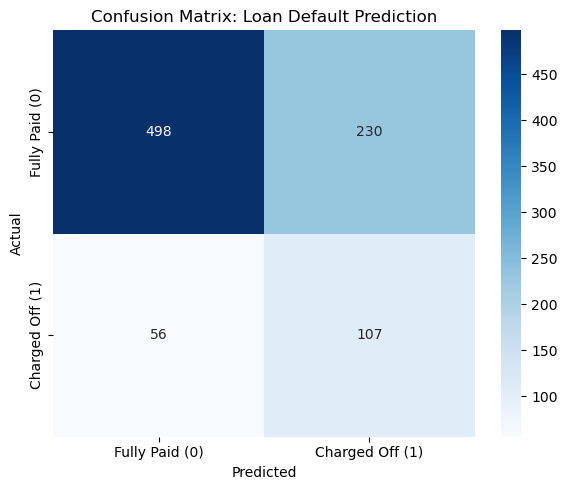

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

labels = ['Fully Paid (0)', 'Charged Off (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Loan Default Prediction')
plt.tight_layout()
plt.show()

# TN (True Negative): The model correctly predicted a borrower as non-defaulter (Fully Paid), and they indeed did not default. (498 cases).
# FP (False Positive): The model predicted a borrower would default, but they actually paid back the loan fully. (230 cases).  
# FN (False Negative): The model predicted a borrower would pay back the loan, but they actually defaulted. (56 cases).
# TP (True Positive): The model correctly predicted a borrower as defaulter (Charged Off), and they indeed defaulted. (107 cases).


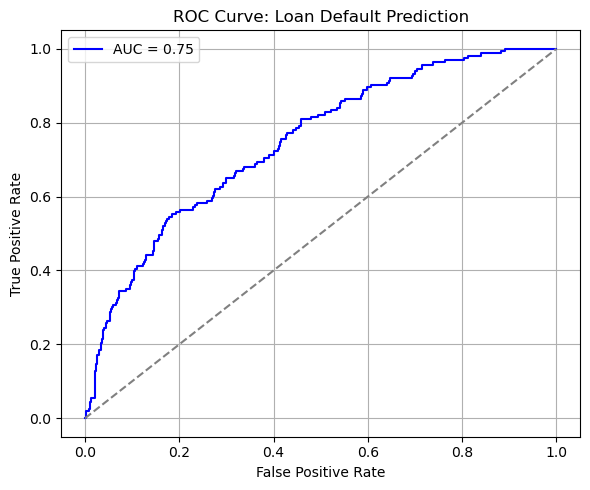

In [25]:
#ROC and AUC score to evaluate performance
from sklearn.metrics import roc_curve, roc_auc_score
# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate") #Sensitivity
plt.title("ROC Curve: Loan Default Prediction")  #(1-Specificity) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 0.75 is not too bad for loan data(which has lots of noise)

In [28]:
auc_score

0.7472106114744151